# Noise Power Spectra

In [1]:
import numpy as np
import astropy.units as u
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
from astropy.cosmology import Planck15 as cosmo
from twentyonecmFAST import load_binary_data
from powerbox.powerbox import get_power
from astropy import constants as const
import xcorr
import sys

## 21cm Noise Auto Spectrum

$$\sigma_{21}^2 = \left[ P_{21}\left(k, \mu \right) + \frac{T^2_{\rm sys} V_{\rm sur}}{B \ t_{\rm int} \ n \left(k_{\perp}\right)} {\rm W}_{21}\left(k, \mu \right) \right]$$

$$ {\rm W}_{21}\left(k, \mu \right) = e^{\left(k_{\parallel} / k_{\parallel, \rm res} \right)^2 + \left(k_{\perp} / k_{\perp, \rm res} \right)^2}$$

$$k_{\parallel, \rm res} = \frac{R_{\rm res} H \left( z\right)}{c \left(1 + z\right)} = \frac{1}{\Delta x_{\parallel, \rm res}}$$

Ra $R_{\rm res} = \nu_{21} \left( z \right) / \nu_{\rm res}$

$$k_{\perp, \rm res} = \frac{1}{\chi \left( z \right) \theta_{\rm min}} = \frac{1}{\Delta x_{\perp, \rm res}}$$

Here's some text

$$\theta_{\rm min} = \left( x_{\rm pix} / 60 \right) \left(\pi / 180 \right)$$

Here's some text

$$x_{\rm pix} = \lambda_{21} \left( z \right) / l_{\rm max}$$

Reasonable estimates for HERA: $T_{\rm sys} \approx 200 \ {\rm K}$, $B = 8 \ {\rm MHz}$, $t_{\rm int} = 1000 \ {\rm hr}$

In [2]:
c = 3e8 * u.m / u.second

In [3]:
def variance_21cm(P, k_perp, k_par, z):
    return (P + W_21(k_perp, k_par, z) * therm(z))

def W_21(k_perp, k_par, z):
    return np.exp((k_par / k_par_res(z).value) ** 2 + (k_perp / k_perp_res(z).value) ** 2)


def therm(z, Tsys = 400 * u.K, B = 8 * u.MHz, t_int = 1000 * u.hr, n = 0.8):
    """Thermal noise component
    """
    return (V_sur(z) * Tsys ** 2 / (B * t_int * n)).to(u.Mpc ** 3 * u.mK ** 2)

"""
Parallel Mode Resolution
"""

def k_par_res(z):
    return 2 * np.pi * (R_res(z) * cosmo.H(z) / (c * (1 + z))).to(u.Mpc ** -1)

def R_res(z, nu_res = 3.9e3):
    """
    """
    return ((1420 * u.MHz) / ((1 + z) * (nu_res * u.Hz))).to(u.dimensionless_unscaled)


"""
Perpendicular Mode Resolution
"""

def k_perp_res(z):
    return 2 * np.pi / (cosmo.comoving_distance(z) * theta_min(z))

def theta_min(z):
    '''
    Theta
    '''
    def x_pix(z, l_max = 1e5):
        '''
        Parameters:
            z: (float)
                redshift
            l_max: (float)
                Maximum baseline length

        Returns 
        '''
        l_21 = 21 * u.cm
        return (l_21 * (z + 1) / (l_max * u.cm)) * (np.pi / 180) / 60.
    
    return x_pix(z)


In [4]:
def N_m(z):
    return V_sur(z) * d_k * d_mu * k ** 2 / (4 * np.pi)

def A_eff(D, ants = 350):
    return ants * np.pi * (D ** 2.0) / 4

def V_sur(z, A = 925 * u.m ** 2):
    l_21 = (21.1 * u.cm) * (1 + z)
    return (cosmo.comoving_distance(z) ** 2 * survey_depth(z) * (l_21 ** 2.0 / A) ** 2).to(u.Mpc ** 3)


def survey_depth(z, B = 8 * u.MHz):
    """1708.06291.pdf
    """
    return 1.7 * (B / (0.1 * u.MHz)) * ((1 + z) / 10) ** 0.5 * (cosmo.Om(z) * cosmo.h ** 2 / 0.15) ** -2 * u.Mpc

In [6]:
z = 7.04

In [15]:
V_sur(z) * 100.

<Quantity 1006683.57020235 Mpc3>

## Ly$\alpha$ Noise Auto Spectrum

## 21cm-Ly$\alpha$ Cross-Power Spectrum Variance

$$\sigma_{21,{\rm Ly}\alpha}^2 \left(k, \mu \right) = \frac{1}{2}\left[ P_{21,{\rm Ly}\alpha}^2 \left(k, \mu \right) + \sigma_{21} \left(k, \mu \right) \sigma_{\rm Ly \alpha} \left(k, \mu \right) \right]$$

In [8]:
z = 7.04

In [9]:
temp_21 = load_binary_data('../../data/delta_T_v3_z007.04_nf0.233584_useTs1_256_200Mpc')
temp_21 = np.reshape(temp_21, (256,256,256))

In [10]:
ps, k = xcorr.dimensional_ps(temp_21, 200, log_bins = True, bins = 14)
ps_2d, k_perp, k_par = xcorr.get_power(temp_21, 200, log_bins = True, bins = 14, res_ndim = 2)
scaled_ps = temp_21.mean() ** 2 * u.mK ** 2 * u.Mpc ** 3 * ps_2d

In [11]:
sig_v = variance_21cm(scaled_ps, k_perp[:, np.newaxis], k_par, z)

In [12]:
kpar, kperp = np.meshgrid(k_par, k_perp)
k_vals = np.sqrt(kpar ** 2 + kperp ** 2)
k_bins = np.logspace(np.log10(k_vals.min()), np.log10(k_vals.max()), 14)
idx = np.digitize(k_vals, k_bins, right = True)

p_calc = np.zeros((14))

for i in np.arange(14):
    i1, i2 = np.where(idx == i)
    p_calc[i] = 1.0 / np.sum(sig_v[i1, i2].shape[0] / (sig_v[i1, i2].value))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


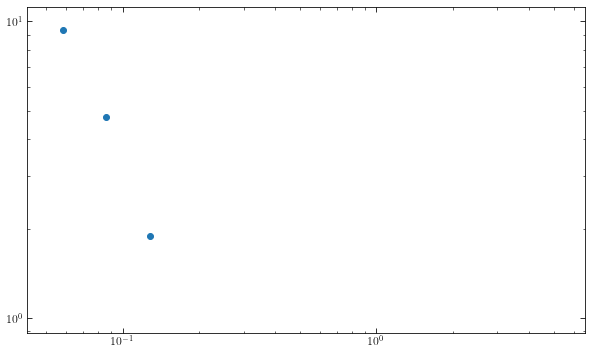

In [13]:
plt.figure(figsize=(10,6))
plt.scatter(k, k ** 3 / (2 * np.pi ** 2) * p_calc)
plt.xscale('log')
plt.yscale('log')
plt.show()

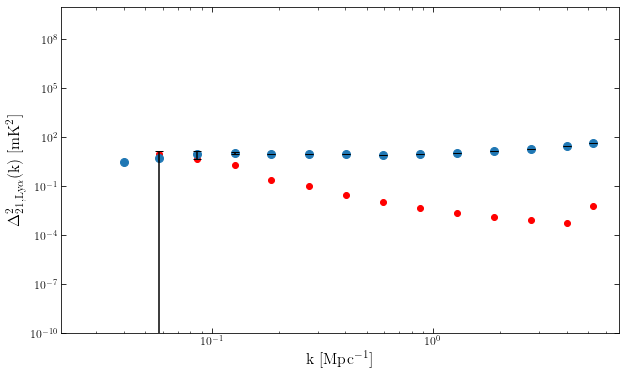

In [32]:
plt.figure(figsize=(10,6))
plt.errorbar(k, ps, yerr = k ** 3 / (2 * np.pi ** 2) * p_calc, fmt = 'o',
             ecolor = 'black', barsabove = True, markersize=8, capsize=4)
plt.scatter(k, k ** 3 / (2 * np.pi ** 2) * p_calc, color = 'red')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-10, 1e10])
plt.xlabel('k [Mpc$^{-1}$]', fontsize = 16)
plt.ylabel(r'$\Delta^2_{21,\rm{Ly} \alpha} (\rm k)$ [mK$^2$]', fontsize = 16)
plt.show()

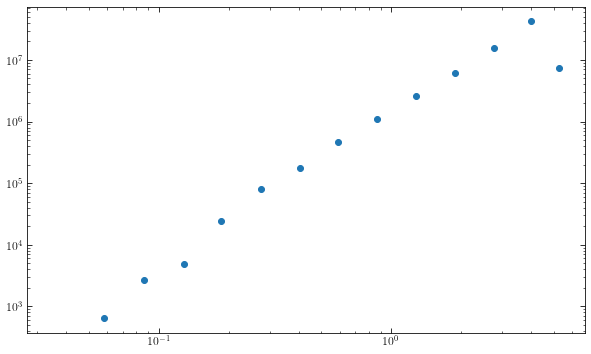

In [184]:
plt.figure(figsize=(10,6))
plt.scatter(k, ps / (k ** 3 / (2 * np.pi ** 2) * p_calc))
plt.plot(k, ps / (k ** 3 / (2 * np.pi ** 2) * p_calc), alpha = 0)
plt.xscale('log')
plt.yscale('log')
plt.show()